In [298]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns


In [302]:
# Read it in.
survey2011 = pd.read_csv('../data/hd2011.csv', encoding = "ISO-8859-1")
survey2012 = pd.read_csv('../data/hd2012.csv', encoding = "ISO-8859-1")
peps = pd.read_excel('../data/peps300.xlsx')

# Do some fixing and plumbing
#survey2011['OPEID_CLEAN'] = [value[2:] for value in post['OPEID'].values]  // I don't know why you guys are doing this, so I just choose not to use it for now
#peps['OPEID_CLEAN'] = [str(value) for value in peps['OPEID_CLEAN'].values]

# pepsG = the first 11 and columns which we used for both train and test
pepsG = peps.iloc[:, :11]
pepsG['OPEID'] = pepsG['OPEID_CLEAN']
pepsG = pepsG.drop('OPEID_CLEAN', axis =1)
pepsG['Ethnic Code'] = peps['Ethnic Code']
pepsG['Average or\nGreater than 30'] = peps['Average or\nGreater than 30']


#prepare the train set/2011
peps11 = peps.iloc[:, 27:31]
train = pd.merge(pepsG, peps11,left_index = True, right_index=True)



#prepare the test set/2012
peps12 = peps.iloc[:, 22:26]
test = pd.merge(pepsG, peps12,left_index = True, right_index=True)

# Merge our datasets.
train = pd.merge(survey2011, train, on='OPEID')
test = pd.merge(survey2012, test, on = 'OPEID')



/Users/Wang/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


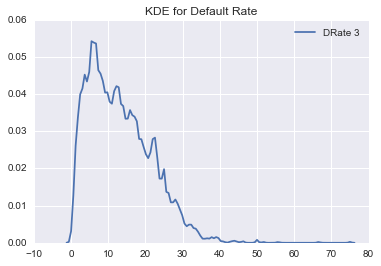

In [303]:
# ASK BRIAN:
#  CBSA: population density measure
#    CBSATYPE
#    CSA
#  Congressional district

# Not including geo-location features like zip code, county.
# TODO: revisit Latitude and Longitude for visualization.


#the only difference between two arrays is DRate 2 and DRate 3
featuresTRAIN = ['UNITID',
            'CONTROL',
            'GROFFER',
            'HBCU',
            'HLOFFER',
            'HOSPITAL',
            'ICLEVEL',
            'INSTCAT',
            'INSTSIZE',
            'LANDGRNT', # Revisit
            'LOCALE',
            'PSEFLAG',
            'SECTOR',
            'Prog\nLength',
            'School\nType',
#             '\nDenom 1',
#             '\nNum 1',
            'UGOFFER',
            'DRate 3',
            'Ethnic Code',
            'Average or\nGreater than 30']


featuresTEST = ['UNITID',
            'CONTROL',
            'GROFFER',
            'HBCU',
            'HLOFFER',
            'HOSPITAL',
            'ICLEVEL',
            'INSTCAT',
            'INSTSIZE',
            'LANDGRNT', # Revisit
            'LOCALE',
            'PSEFLAG',
            'SECTOR',
            'Prog\nLength',
            'School\nType',
#             '\nDenom 1',
#             '\nNum 1',
            'UGOFFER',
            'DRate 2',
            'Ethnic Code',
            'Average or\nGreater than 30']



ax = plt.axes()
ax.set_title("KDE for Default Rate")
kde = sns.kdeplot(train['DRate 3'], bw = 0.4)
fig = kde.get_figure()
fig.savefig("kde_plot.png")

In [304]:
# Master dataset!!
train = train[featuresTRAIN]
test = test[featuresTEST]

#change the name to DRate for the convenience of future usage
train['DRate'] = train['DRate 3']
test['DRate'] = test['DRate 2']
train = train.drop('DRate 3', axis = 1)
test = test.drop('DRate 2', axis = 1)


# np.nanmedian(train['DRate'] == 11.4
# np.nanmedian(test['DRate'] == 10.0


med = np.nanmedian(train['DRate'])

train['DRate_Transformed'] = train['DRate'] > med
train['DRate_Transformed'] = train['DRate_Transformed'].astype(int)

# TODO eventually re-add this statement
#train = train.drop('DRate', axis = 1)



11.4


In [305]:
# Our initial model works with THIS dataset.
train.to_csv("../data/trainRAW.csv", index=False)
test.to_csv("../data/testRAW.csv", index=False)

In [306]:
ipeds = pd.read_csv("../data/delta_public_00_12.csv", encoding="ISO-8859-1")

/Users/Wang/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [307]:
ipeds['is_2011'] = ipeds['academicyear'] == 2011
ipeds2011 = ipeds[ipeds['is_2011']]

ipeds['is_2012'] = ipeds['academicyear'] == 2012
ipeds2012 = ipeds[ipeds['is_2012']]

In [308]:
# REMOVE instname, unitid WHEN DONE

ipeds_features ="""
instname
unitid
sector
iclevel
control
census_region
hbcu
hsi
cpi_index
hepi_index
has_fte
nettuition01
net_student_tuition
endowment03
priv_invest_endow
total03_revenue
restricted_revenue
grant01
grant02
grant07
tuition_discount
institutional_grant_aid_share
fed_grant_pct
inst_grant_pct
loan_pct
loan_avg_amount
inst_grant_avg_amount
tuitionfee02_tf
studserv01
acadsupp01
sticker_price_share
nettuition_share
totaldegrees_100fte
certificates_awards_100fte
totalcompletions_100fte
ft_first_time_first_yr_deg_seek
total_full_time
total_enrollment_asian_tot
total_enrollment_black_tot
total_enrollment_hisp_tot
total_enrollment_white_tot
ft_faculty_per_100fte
pt_faculty_per_100fte
salarytotal""".split()

# Isolate wanted columns, map column headers to uppercase for join.
ipeds2011 = ipeds2011[ipeds_features]
ipeds2012 = ipeds2012[ipeds_features]
ipeds2011.columns = map(str.upper, ipeds2011.columns)
ipeds2012.columns = map(str.upper, ipeds2012.columns)



In [309]:
# Merge :joined and :ipeds on the UNITID column.
train = pd.merge(train, ipeds2011, on="UNITID")



test = pd.merge(test, ipeds2012, on="UNITID")

In [310]:
train[train['UNITID'] == 103811].INSTNAME

49    American Institute of Technology
Name: INSTNAME, dtype: object

In [311]:
# Set our institution's UNITID to be its index, drop
# the corresponding UNITID column.
train.index = train['UNITID']
train = train.drop("UNITID", axis = 1)

test.index = test['UNITID']
test = test.drop("UNITID", axis = 1)


# Leave this here please :)
'''
master_copy = master
master_copy.index = master_copy['INSTNAME']
master_copy = master_copy.drop("INSTNAME", axis = 1)'''

'\nmaster_copy = master\nmaster_copy.index = master_copy[\'INSTNAME\']\nmaster_copy = master_copy.drop("INSTNAME", axis = 1)'

In [312]:
# Master dataset to check if features are imputable
train.to_csv("../data/trainFINAL.csv")
test.to_csv("../data/testFINAL.csv")

In [1]:
imputable = """
STUDSERV01
TOTAL03_REVENUE
TOTALCOMPLETIONS_100FTE
TOTAL_ENROLLMENT_ASIAN_TOT
TOTAL_ENROLLMENT_BLACK_TOT
TOTAL_ENROLLMENT_HISP_TOT
TOTAL_ENROLLMENT_WHITE_TOT
""".split()

ipeds2011 = ipeds2011[imputable]
ipeds2012 = ipeds2012[imputable]




['STUDSERV01', 'TOTAL03_REVENUE', 'TOTALCOMPLETIONS_100FTE', 'TOTAL_ENROLLMENT_ASIAN_TOT', 'TOTAL_ENROLLMENT_BLACK_TOT', 'TOTAL_ENROLLMENT_HISP_TOT', 'TOTAL_ENROLLMENT_WHITE_TOT']


In [13]:
pd.isnull(master).any()
nans = pd.isnull(master)
nans_copy = pd.isnull(master_copy)

from collections import Counter

university_nans = Counter()
column_count_nans = Counter()

for index, row in zip(nans_copy.index, nans_copy.values):
    row_data = dict(zip(nans_copy.columns.values, row))

    for column, value in row_data.items():
        if value:
            university_nans[index] += 1
            column_count_nans[column] += 1

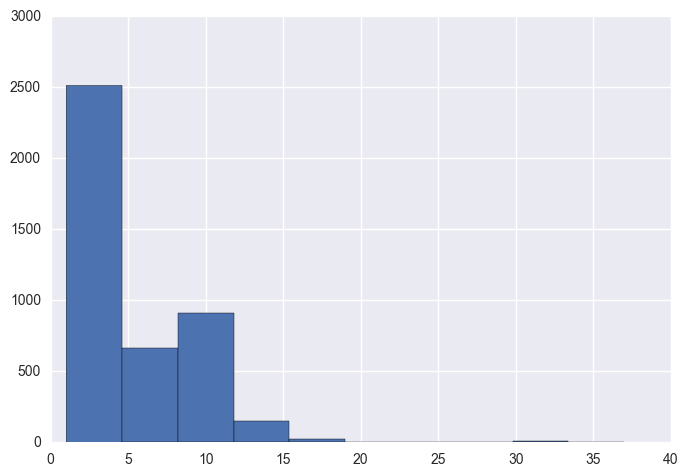

In [14]:
# A good number of our institutions have between 0 and 10 NaN values.
university_nan_dist = pd.DataFrame.from_dict(university_nans, orient='index').reset_index()
university_nan_dist = university_nan_dist.rename(columns={'index':'event', 0:'count'})
plt.hist(university_nan_dist['count'])
plt.show()

In [15]:
column_nan_dist = pd.DataFrame.from_dict(column_count_nans, orient='index').reset_index()
column_nan_dist = column_nan_dist.rename(columns={'index':'event', 0:'count'})
column_nan_dist['count'] = column_nan_dist['count'].astype(int)

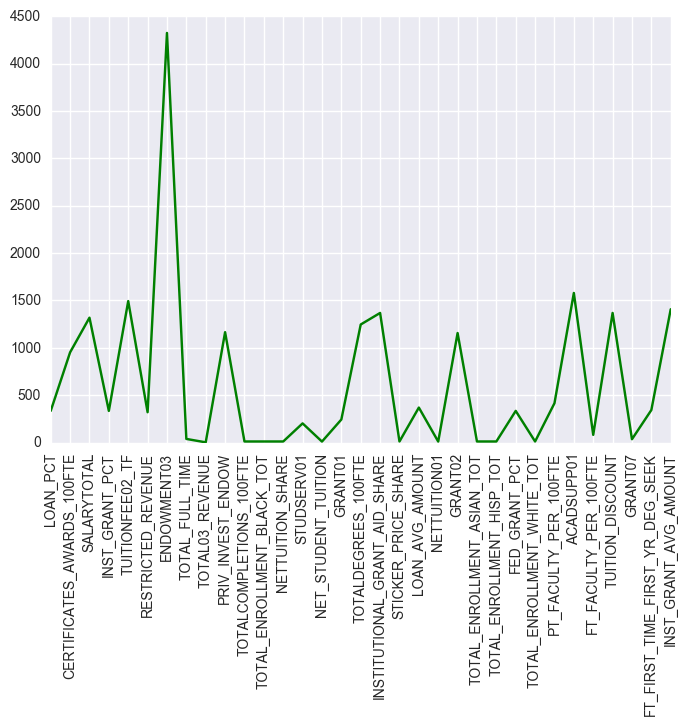

In [16]:
# Plot new features against their NaN count

fig, ax = plt.subplots()
x = range(len(column_nan_dist['event']))
plt.xticks(x, column_nan_dist['event'])
ax.set_xticklabels(column_nan_dist['event'], rotation = 90)
plt.plot(x, column_nan_dist['count'], "g")
plt.show()

In [17]:
# master = master.drop('ENDOWMENT03', axis = 1)

In [18]:
# Isolate rows where master contains no missing values
not_nans = master.dropna(axis=0)

In [19]:
# Get percent of valid rows in master
valid_percent_of_master = 1 - (master.shape[0] - not_nans.shape[0]) / master.shape[0]
valid_percent_of_master

0.0

ValueError: zero-size array to reduction operation minimum which has no identity

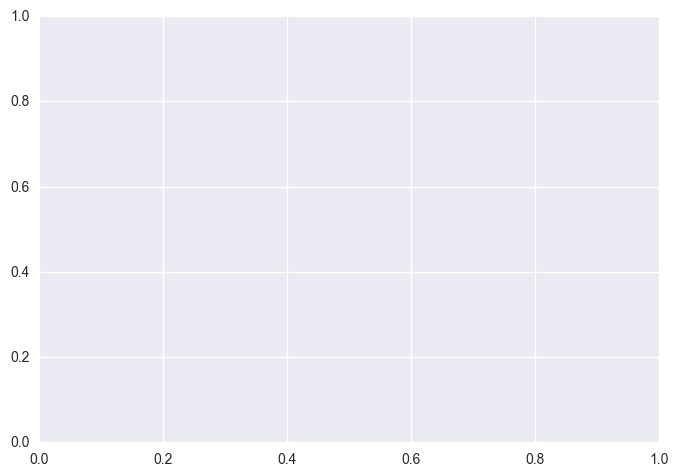

In [20]:
# Plot new default rate based on just the valid rows after dropping ENDOWMENT03
ax.set_title("KDE for Default Rate")
kde = sns.kdeplot(not_nans['DRate 1'], bw = 0.4)

In [ ]:
# Get the distribution median for this non-null dataset.
# Note that the median declined from 9.8 to 9.2
np.median(not_nans['DRate 1'])